In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
# from run_mcts import Game, StabilityNode

# G = Game(StabilityNode, 'C')
# node = G.run_mcts().__next__()

In [3]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [4]:
config.experiment_id

'001'

Text(0.5, 0, 'Time (hours)')

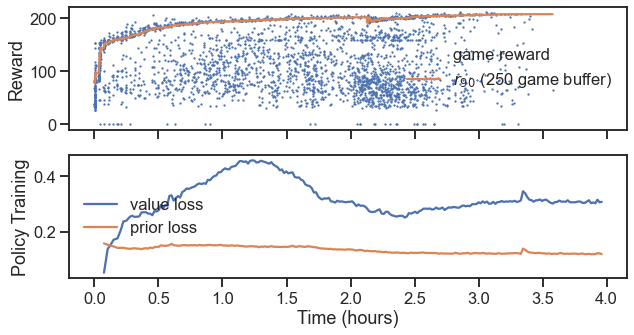

In [5]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time_hours, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

# axs[0].set_ylim([0, 150])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

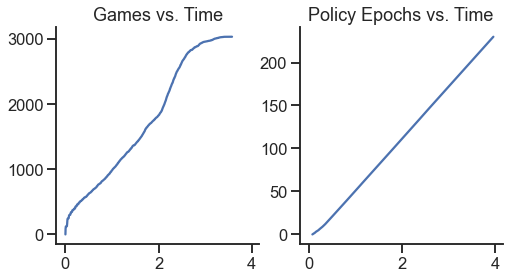

In [6]:
fig, axs = plt.subplots(figsize=(8,4), sharex=True, ncols=2)
axs[0].plot(df.time_hours, df.index)
axs[1].plot(log.time_hours, log.index)

axs[0].set_title('Games vs. Time')
axs[1].set_title('Policy Epochs vs. Time')

sns.despine()

In [7]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

,experiment_id
0,001


In [8]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(906372, 10)

In [9]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
827249,CCC(C)(C)C(=C([O])SC)C(C)(C)CC,2021-01-08 21:21:26.723391,214.19568,C,84.225380,0.346735,5,1.093520,-0.398281,69.792330
822230,CCC(C)(C)C(=C([O])C(C)C)C(C)(C)S,2021-01-08 21:19:35.020406,212.08030,C,82.931050,0.223549,5,1.136255,-0.420696,73.196304
494463,CC(C)C(C)(C)C(=C([O])NO)C(C)(C)C,2021-01-08 20:06:58.998834,211.88861,C,79.664925,0.317844,6,1.099058,-0.385194,64.091570
833487,CCCC(=C(C)C)C(=C([O])S)C(C)(C)C,2021-01-08 21:23:21.756341,211.67693,C,77.050285,0.301058,7,0.880081,-0.386324,67.182630
472026,C=CC(C)(C)C(=C([O])C(C)C)C(C)(C)C,2021-01-08 20:03:29.129138,211.51620,C,79.170616,0.277006,5,1.093276,-0.408896,73.271850
838060,C=CC(C)(C)C(=C([O])CC)C(C)(C)CC,2021-01-08 21:24:50.575447,211.22615,C,80.324960,0.299387,5,1.084800,-0.394858,77.396680
196504,CCC(C)(C)c1c(C)coc1C(C)=C[O],2021-01-08 19:26:09.987572,211.10988,C,73.364920,0.245101,5,0.880136,-0.256733,72.018410
888017,CC([O])=C(C(C)(C)CO)C(C)(C)C(C)C,2021-01-08 21:51:14.237512,211.09170,C,80.626900,0.365953,3,1.050751,-0.394884,76.196450
831580,CCC(C)(CC)C(=C(C)[O])C(C)(C)S,2021-01-08 21:22:46.178230,211.09134,C,82.208640,0.287389,6,1.083935,-0.397446,78.045690
604120,CCC(C)(C)C(=C([O])S)C(C)=C(C)C,2021-01-08 20:25:40.589557,210.96867,C,77.996800,0.340563,5,0.853371,-0.348924,67.222520


In [10]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [11]:
from rdkit import Chem

INFO:rdkit:Enabling RDKit 2020.03.4 jupyter extensions


In [12]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [13]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde


In [14]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [15]:
pass_gng.shape

(3871, 10)

In [26]:
pass_gng.to_csv('20210109_gng_radicals.csv.gz', compression='gzip')

In [29]:
from reward import redox_model, predict

In [30]:
from alphazero.node import Node

In [44]:
import tensorflow as tf

In [45]:
def pred_redox(smiles):
    return predict(redox_model,
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(rdkit.Chem.MolFromSmiles(smiles)).policy_inputs.items()}).numpy().flatten()

In [48]:
from tqdm import tqdm
tqdm.pandas()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [49]:
redox = pass_gng.smiles.progress_apply(pred_redox)

100%|██████████| 3871/3871 [00:45<00:00, 85.81it/s] 


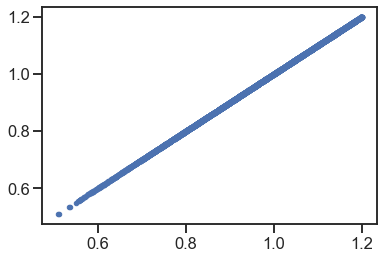

In [57]:
plt.plot(np.vstack(redox.values)[:, 0], pass_gng.ie, '.')

In [59]:
(pass_gng.ie - np.vstack(redox.values)[:, 0]).abs().mean()

1.1796256145951268e-07

In [61]:
Node(rdkit.Chem.MolFromSmiles('CC(=S)C1=C(C)[CH]CCC1(C)C')).policy_inputs

{'atom': array([  8,   4, 107,  24,  24,   8,  27,  26,  26,  52,   8,   8]),
 'bond': array([ 3,  3, 70,  3, 71,  3, 41, 14, 41,  3, 14,  3, 14, 14, 14, 14, 14,
        14, 14,  3,  3, 14,  3,  3]),
 'connectivity': array([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 2,  1],
        [ 3,  1],
        [ 3,  4],
        [ 3,  9],
        [ 4,  3],
        [ 4,  5],
        [ 4,  6],
        [ 5,  4],
        [ 6,  4],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 11],
        [ 9,  3],
        [10,  9],
        [11,  9]])}

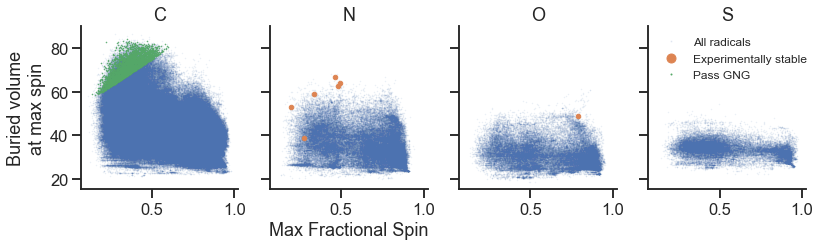

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

Text(0, 0.5, '$E_{1/2}^o$, IE (V)')

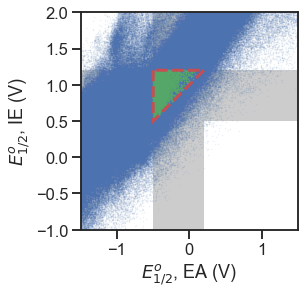

In [17]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

Text(0, 0.5, 'Frequency')

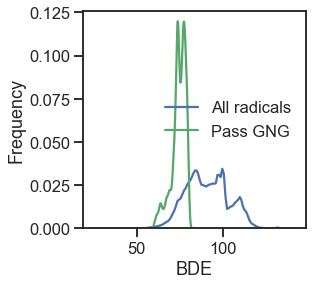

In [18]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [19]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [28]:
pass_gng.sample(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
892224,CCC(C)(C)C(=C[O])C(C)=C(C)C1CC1,2021-01-08 21:56:34.164474,199.27992,C,71.735430,0.363578,5,0.750799,-0.423248,74.092480
476745,CCOC=C(C(=C(C)[O])C(C)C)C1CC1,2021-01-08 20:04:12.055707,176.41980,C,67.384880,0.342571,5,0.563763,-0.480182,74.264710
882835,C=C(CCCN)C(=C[O])C(C)(C)C(C)C,2021-01-08 21:46:51.325143,181.90662,C,73.376500,0.360514,6,1.185533,-0.356704,79.998474
616893,C=C1CCC(=C[O])C(CCC)=C1C1CC1,2021-01-08 20:27:51.359872,200.36533,C,66.520130,0.261526,11,0.945646,-0.412066,73.860030
407403,CC(C)(C)C1=C([CH]O)N(N)C(=O)C1=O,2021-01-08 19:53:58.330850,194.07002,C,65.713875,0.304136,4,1.072133,-0.280756,78.383210
790974,C=C(C)C(CC)=C([O])C(=CC)C(C)(C)C,2021-01-08 21:09:28.460353,199.12976,C,65.013030,0.275271,3,0.954504,-0.392349,76.974330
590393,CCC(C)(C)C1=C2[CH]CN=C2C(=O)C=C1,2021-01-08 20:23:16.996943,202.30370,C,67.298520,0.299897,5,1.078131,-0.371719,74.726870
897926,CCC(=C[O])C(O)=C(CCOC)C(C)C,2021-01-08 22:04:49.026450,190.39603,C,66.520020,0.323712,7,1.176092,-0.263833,73.957960
840488,CCC=C(CCC)C(=C([O])O)C(C)(C)C,2021-01-08 21:25:47.389279,192.33238,C,73.155800,0.394443,7,0.952351,-0.486945,63.755653
775835,CN(C)C(C)(C)C(=C([O])CN)C(C)(C)C,2021-01-08 21:04:13.037079,189.39030,C,80.761490,0.466928,6,1.105792,-0.460888,78.615740


In [20]:
rew_df[rew_df.real_reward > 200]

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
171546,CCC(C)(CC)C1=C([CH]O)CC(=O)C1=O,2021-01-08 19:22:51.097220,206.64190,C,72.549900,0.318160,6,0.839778,-0.339148,72.538820
176025,C=C(C)C([O])=C(C(=C)C)C(C)(C)C,2021-01-08 19:23:21.656546,200.21400,C,72.855034,0.452820,5,1.024527,-0.312464,74.842410
176057,CC=CC(=C(C)[O])C(C)(C)C(=O)C(C)C,2021-01-08 19:23:21.841516,201.80025,C,69.760860,0.359212,3,0.954078,-0.380836,73.888214
196504,CCC(C)(C)c1c(C)coc1C(C)=C[O],2021-01-08 19:26:09.987572,211.10988,C,73.364920,0.245101,5,0.880136,-0.256733,72.018410
217545,CC(C)(O)C1=C([CH]O)C(C)(C)C(=O)C1=O,2021-01-08 19:28:31.181782,200.05998,C,67.620590,0.351212,4,0.893969,-0.283790,73.357560
...,...,...,...,...,...,...,...,...,...,...
905802,CC1=C(C(C)(C)CO)CCCCC1=C[O],2021-01-08 22:19:12.334447,201.91116,C,71.310110,0.341700,2,0.832788,-0.404930,73.681140
905862,CC1(C2=C(CO)C(=C[O])CCCC2)CC1,2021-01-08 22:19:17.418917,200.95381,C,66.939705,0.319718,2,0.836775,-0.282944,73.860040
906007,CC1=C(C2(CO)CC2)CCCCC1=C[O],2021-01-08 22:19:33.331119,200.70130,C,67.679500,0.339564,2,0.849947,-0.353376,73.681140
906140,CCC(CCCO)=C(C(O)=C[O])C(C)C,2021-01-08 22:21:38.576505,202.81894,C,70.061260,0.344846,2,0.851959,-0.362598,70.679670


In [21]:
rew_df.real_reward.max()

214.19568

(array([6.00000e+00, 4.10000e+01, 8.10000e+01, 3.34000e+02, 1.33500e+03,
        4.22700e+03, 1.30160e+04, 3.80680e+04, 6.94810e+04, 1.47577e+05,
        2.47330e+05, 1.64106e+05, 1.12409e+05, 8.02860e+04, 1.73680e+04,
        6.69700e+03, 3.15300e+03, 7.52000e+02, 9.50000e+01, 1.00000e+01]),
 array([-1.1102562 , -0.87093664, -0.63161708, -0.39229752, -0.15297796,
         0.08634159,  0.32566115,  0.56498071,  0.80430027,  1.04361983,
         1.28293939,  1.52225895,  1.76157851,  2.00089807,  2.24021763,
         2.47953719,  2.71885674,  2.9581763 ,  3.19749586,  3.43681542,
         3.67613498]),
 <BarContainer object of 20 artists>)

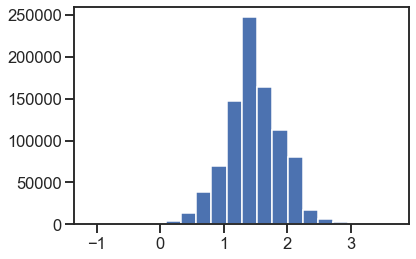

In [22]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

Text(0, 0.5, 'Frequency')

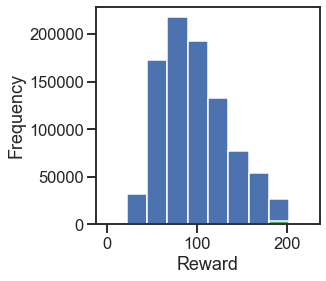

In [24]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())